In [1]:
## Treat larger sequence 

In [3]:
import os
import NN
import utils
from torch import save as save_model
from torch import load as load_model
import config as cfg
import pandas as pd
import seaborn as sns
import numpy as np
import torch
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [4]:
ETF = 'SPY' # 'SPY', 'DIA', 'QQQ'
NNtype = 'MLP' # 'MLP', 'RNN', 'PSN'
params = cfg.train_parameters[ETF][NNtype]
inputs_lag = cfg.SPYfeatures[NNtype] # SPYfeatures, DIAfeatures, QQQfeatures

In [5]:
traindf = utils.load_file(os.path.join("data", ETF, NNtype, "Train.pkl"))
validdf = utils.load_file(os.path.join("data", ETF, NNtype, "Valid.pkl"))
testdf  = utils.load_file(os.path.join("data", ETF, NNtype, "Test.pkl"))
traindf.head()


,Adj Close,Return,Return_1,Return_3,Return_5,Return_7,Return_8,Return_9,Return_12,Target
Date,,,,,,,,,,
2011-01-03,105.443665,0.010285,0.000239,0.000715,0.000398,0.003106,0.006320,0.002410,-0.004583,0.010285
2011-01-04,105.385559,-0.000551,0.010285,-0.001590,0.001432,-0.001432,0.003106,0.006320,0.005785,-0.000551
2011-01-05,105.933296,0.005184,-0.000551,0.000239,0.000715,0.000398,-0.001432,0.003106,0.001071,0.005184
2011-01-06,105.725830,-0.001960,0.005184,0.010285,-0.001590,0.001432,0.000398,-0.001432,0.002410,-0.001960
2011-01-07,105.518341,-0.001964,-0.001960,-0.000551,0.000239,0.000715,0.001432,0.000398,0.006320,-0.001964


In [21]:
features_col = []
for i in inputs_lag:
    features_col.append("Return_" + str(i))
target_col   = 'Target'

mu_train, sigma_train = traindf.Return.mean(), traindf.Return.std()
mu_val, sigma_val = validdf.Return.mean(), validdf.Return.std()
mu_test, sigma_test = testdf.Return.mean(), testdf.Return.std()

print(mu_test, sigma_test)
print(len(trainloader))

trainloader = utils.DataFrame2DataLoader(traindf, features_col, target_col, batch_size=1, normalize=True, mu=mu_train, sigma=sigma_train)
validloader = utils.DataFrame2DataLoader(validdf, features_col, target_col, batch_size=1, normalize=True, mu=mu_val, sigma=sigma_val)
testloader  = utils.DataFrame2DataLoader(testdf, features_col, target_col, batch_size=1, normalize=True, mu=mu_test, sigma=sigma_test)

0.00046072151796993163 0.007377619169662766
502


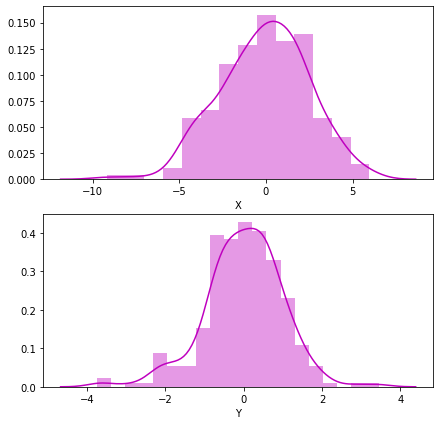

In [7]:
X = []
Y = []
for item in validloader:
    X.append((torch.sum(item[0])/len(item[0])))
    Y.append(item[1])
normal_df = pd.DataFrame(list(zip(X,Y)), columns= ["X","Y"])

f, axes = plt.subplots(2, 1, figsize=(7, 7))
sns.distplot(normal_df["X"], color="m", ax =axes[0])
sns.distplot(normal_df["Y"], color="m", ax= axes[1])


In [10]:
import torch.nn as nn 
loss_function = nn.MSELoss()


class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=70, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers= 2,dropout=0.25 )

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(2,1,self.hidden_layer_size),
                            torch.zeros(2,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]
    


        
model = LSTM()
model.eval()
with torch.no_grad():
    loss_valid = 0
    for seq, labels in validloader:
        y_pred = model(seq.squeeze())
        loss_valid += loss_function((y_pred ), (labels))
        #loss_valid += loss_function((y_pred + mu_val) * sigma_val, (labels + mu_val) * sigma_val)

    loss_train = 0 
    for seq, labels in trainloader:
        y_pred = model(seq.squeeze())
        loss_train += loss_function((y_pred), labels )

        #loss_train += loss_function((y_pred + mu_train) * sigma_train, (labels + mu_train) * sigma_train)
print("Metrics with random init")
print(f'train_loss: {loss_train:10.10f} val_loss: {loss_valid:10.10f} ')


Metrics with random init
train_loss: 502.5148315430 val_loss: 251.7697601318 


In [ ]:
epochs = 70
train_loss = []
val_loss = []
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
for i in range(epochs):
    for seq, labels in trainloader:
        model.train()
        optimizer.zero_grad()

        model.hidden_cell = (torch.zeros(2, 1, model.hidden_layer_size),
                        torch.zeros(2, 1, model.hidden_layer_size))

        y_pred = model(seq.squeeze())

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()
        
    ###############################
    ###########Validation##########
    ###############################
    if i%25 == 1:
        model.eval()
        with torch.no_grad():
            loss_valid = 0
            for seq, labels in validloader:
                y_pred = model(seq.squeeze())
                loss_valid += loss_function((y_pred ), (labels))
                #loss_valid += loss_function((y_pred + mu_val) * sigma_val, (labels + mu_val) * sigma_val)

            val_loss.append(loss_valid.item())
            loss_train = 0 
            for seq, labels in trainloader:
                y_pred = model(seq.squeeze())
                loss_train += loss_function((y_pred), labels )

                #loss_train += loss_function((y_pred + mu_train) * sigma_train, (labels + mu_train) * sigma_train)
            train_loss.append(loss_train.item())
        print(f'epoch: {i:3} train_loss: {loss_train:10.10f} val_loss: {loss_valid:10.10f} ')

        
plt.plot(train_loss)
plt.plot(val_loss)

In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from utils import mean_absolute_percentage_error, theilU, PT_test

def evaluate(testloader, mu, sigma):

    valid_targets = []
    valid_preds = []
    with torch.no_grad():
        for seq, target in testloader:
            valid_preds.append(model(seq.squeeze()))
            valid_targets += target.numpy().tolist()


     
    validRMSE = mean_squared_error((valid_targets + mu)* sigma, (valid_preds+mu)*sigma)
    validMAE = mean_absolute_error((valid_targets + mu)* sigma, (valid_preds+mu)*sigma)
    validMAPE = mean_absolute_percentage_error((np.array(valid_targets)+ mu) * sigma , (np.array(valid_preds) + mu) * sigma)
    validTheilU = theilU((np.array(valid_targets)+ mu) * sigma , (np.array(valid_preds) + mu) * sigma)

    print("MAE : {:.4f} |  MAPE  : {:.4f} |  RMSE : {:.5f} | Theil-U {:.4f}".format(validMAE, validMAPE, validRMSE, validTheilU))
    
    plt.plot(valid_targets)
    plt.plot(valid_preds)

MAE : 0.0064 |  MAPE  : 3.3922 |  RMSE : 0.00007 | Theil-U 0.6902


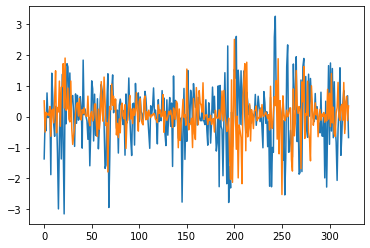

In [13]:
evaluate(testloader, mu_test, sigma_test)

### Predictions

In [20]:
def predict(testloader, mu, sigma):
    predicted_labels = []
    model.eval()
    with torch.no_grad():
        for seq, target in testloader:
            predicted_labels.append(model(seq.squeeze()))
    return (predicted_labels + mu) * sigma

y_hat = predict(testloader, mu_test, sigma_test)
